In [1]:
%load_ext autoreload

%autoreload 2


In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yfinance as yf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df
from src.preprocessing.finbert.sentiment import generate_sentiment_from_title

api_key = '64d11b117233d0.77790833'

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

2023-08-21 21:52:38.691091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 21:52:38.749841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 21:52:38.751032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 21:52:39.813601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data acquisition

In [7]:
start_year = 2009
end_year = 2015
stock = "AMZN"

amzn_news, amzn_complete = get_news(stock,
                                    start_year= start_year,
                                    end_year=end_year)

100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


In [8]:
len(amzn_complete)

0

In [7]:
news_with_amzn = filter_news_with_name(amzn_complete, 'Amazon')

In [8]:
len(news_with_amzn)

7062

In [10]:
sentiment_amzn = generate_sentiment_from_title(
    news_with_amzn,
    tokenizer,
    finbert
)

100%|██████████| 7062/7062 [08:19<00:00, 14.14it/s]


In [11]:
amzn_df = pd.DataFrame(news_with_amzn)[["date","title","content"]]

In [12]:
amzn_df["sentiment"] = sentiment_amzn

In [13]:
save_company_news_df(amzn_df,
                     "amazon")

## Price analysis

In [14]:
amzn_df = read_company_news_df("amazon")

In [15]:
amzn_prices = yf.download(
    'AMZN',
    start='2019-12-30',
    end='2022-12-30'
)

[*********************100%***********************]  1 of 1 completed


In [16]:
amzn_prices.index = pd.to_datetime(amzn_prices.index)

In [17]:
amzn_prices

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-30,93.699997,94.199997,92.030998,92.344498,92.344498,73494000
2019-12-31,92.099998,92.663002,91.611504,92.391998,92.391998,50130000
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
...,...,...,...,...,...,...
2022-12-22,85.519997,85.680000,82.250000,83.790001,83.790001,81431300
2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700
2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000


In [19]:
amzn_df["date"] = pd.to_datetime(amzn_df["date"])
amzn_df["date"] = amzn_df["date"].dt.date

In [20]:
amzn_df = amzn_df\
    .drop_duplicates(subset = "title")

In [21]:
amzn_df["sentiment_count"] = amzn_df["sentiment"].map({
    "neutral": 0 ,
    "positive" : 1,
    "negative" : -1
})

In [22]:
amzn_sentiment = amzn_df[["sentiment_count", "date"]]\
    .groupby("date")\
    .mean()

In [24]:
amzn_sentiment

,sentiment_count
date,
2019-02-27,0.000000
2019-03-11,0.000000
2019-04-15,0.000000
2019-07-16,0.000000
2019-08-28,0.000000
...,...
2022-12-27,0.111111
2022-12-28,0.000000
2022-12-29,0.000000


In [25]:
amzn_sentiment.index = pd.to_datetime(amzn_sentiment.index)

In [27]:
scaler = MinMaxScaler()
prices_norm = scaler.fit_transform(
    amzn_prices[["Close"]]
)

In [28]:
prices_norm_df = pd.DataFrame(
    prices_norm,
    index = amzn_prices.index
)\
    .rename(columns = {
        0: "price"
    })

In [29]:
prices_norm_df

,price
Date,
2019-12-30,0.100472
2019-12-31,0.100926
2020-01-02,0.124873
2020-01-03,0.113875
2020-01-06,0.127197
...,...
2022-12-22,0.018807
2022-12-23,0.032744
2022-12-27,0.011647


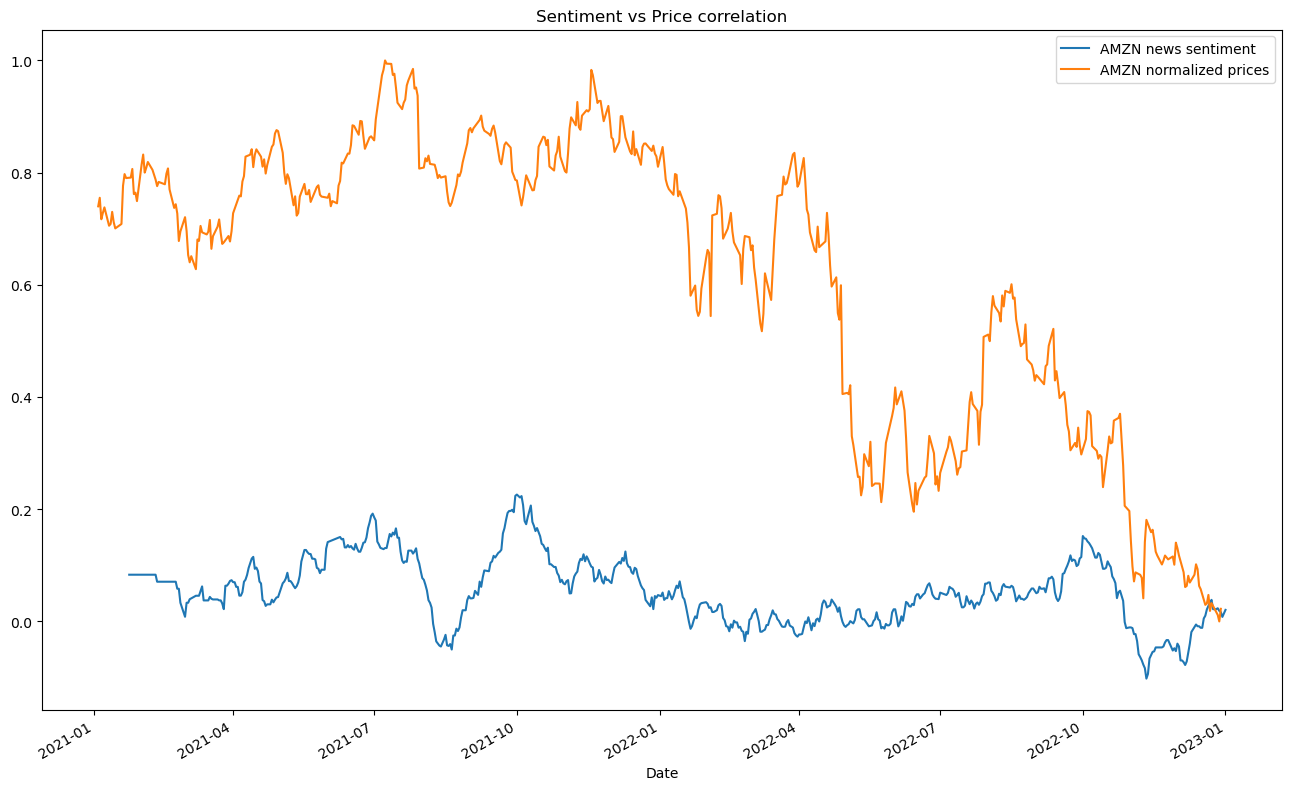

In [30]:
plt.figure(figsize = (16,10))
amzn_sentiment\
    .sentiment_count\
    .rolling(40)\
    .mean()\
    .loc["2021-01":]\
    .plot(
        label = "AMZN news sentiment"
    )

prices_norm_df\
    .price\
    .loc["2021-01":]\
    .plot(
        label = "AMZN normalized prices"
    )

plt.title("Sentiment vs Price correlation")
plt.legend()
plt.show()

In [31]:
prices_norm_df\
    .price\
    .loc["2021-01":]\
    .corr(
amzn_sentiment\
    .sentiment_count\
    .rolling(40)\
    .mean()\
    .loc["2021-01":]
)

0.49444652130809197

In [32]:
slow_ma = amzn_sentiment\
    .sentiment_count\
    .rolling(80)\
    .mean()\
    .loc["2021":]

fast_ma = amzn_sentiment\
    .sentiment_count\
    .rolling(30)\
    .mean()\
    .loc["2021":]

In [33]:
signal = (fast_ma - slow_ma)\
    .apply(lambda x : np.sign(x))\
    .rolling(2)\
    .sum()

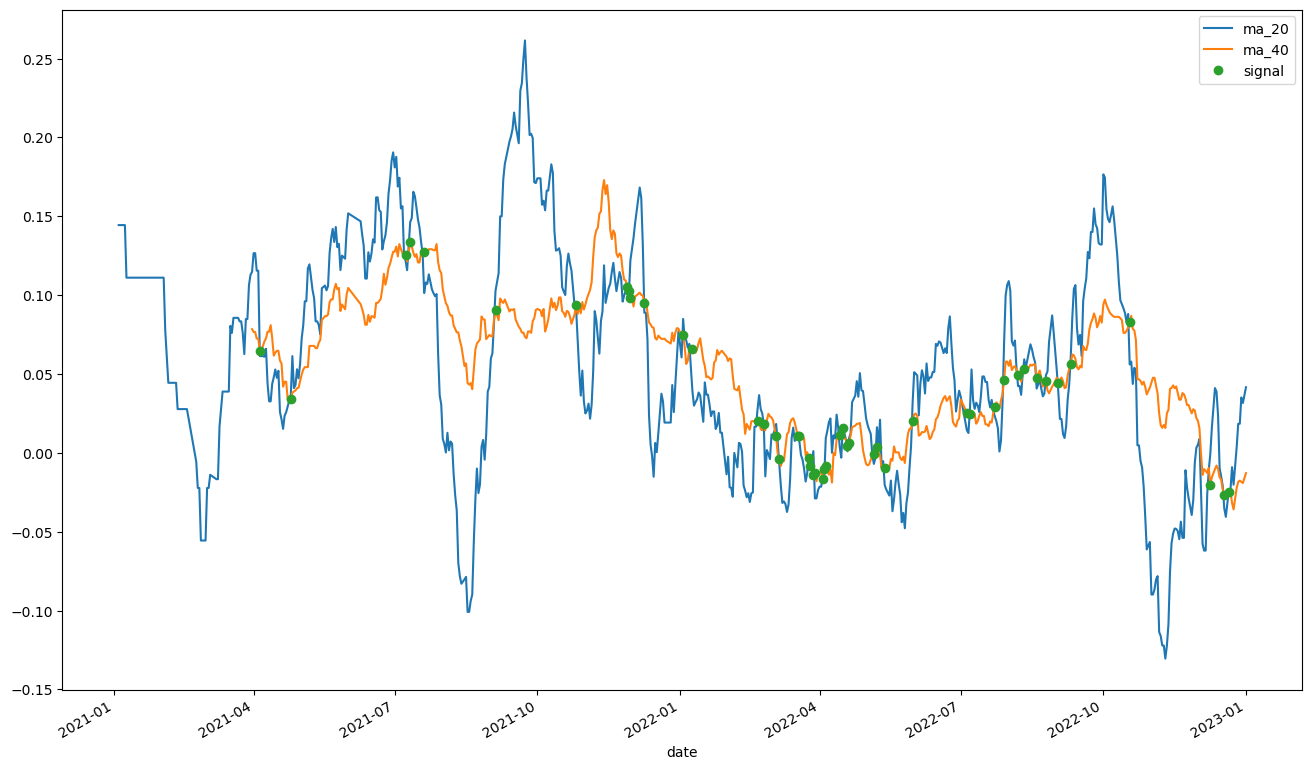

In [35]:
plt.figure(figsize=(16,10))

fast_ma.plot(label = "ma_20")
slow_ma.plot(label = "ma_40")
slow_ma[signal == 0].plot(
    label = "signal",
    marker = "o",
    linestyle = "None"
)

plt.legend()
plt.show()

In [36]:
buy = fast_ma[signal == 0 ] - slow_ma[signal == 0] > 0
sell = fast_ma[signal == 0 ] - slow_ma[signal == 0] < 0

In [37]:
idx = prices_norm_df.index\
    .union(buy.index)\
    .union(sell.index)

In [38]:
idx

DatetimeIndex(['2019-12-30', '2019-12-31', '2020-01-02', '2020-01-03',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13',
               ...
               '2022-12-16', '2022-12-18', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', length=773, freq=None)

In [39]:
buy = buy.reindex(idx)\
    .fillna(False)

sell = sell.reindex(idx)\
    .fillna(False)

In [40]:
prices_norm_plot = prices_norm_df\
    .reindex(idx)

In [41]:

prices_norm_plot.ffill(inplace=True)

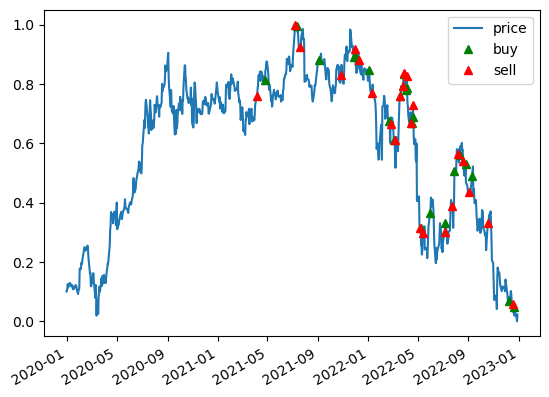

In [42]:
# plt.figure(figsize=(16,10))
prices_norm_plot\
    .price\
    .plot()

prices_norm_plot[buy]\
    .price\
    .plot(
        color = "green",
        marker = "^",
        linestyle = "None",
        label = "buy"
    )

# sell_dates = sell.index
prices_norm_plot[sell]\
    .price\
    .plot(
        color = "red",
        marker = "^",
        linestyle = "None",
        label = "sell"
    )

plt.legend()
plt.show()

In [43]:
prices_norm_plot["position"] = np.nan

In [44]:
prices_norm_plot.loc[buy[buy].index, "position"] = 1
prices_norm_plot.loc[sell[sell].index, "position"] = -1


In [45]:
positions_df = prices_norm_plot\
    .ffill()\
    .fillna(0)

In [46]:
positions_df["real_price"] = amzn_prices\
    .Close\
    .reindex(idx)\
    .ffill()

In [47]:
pnl = pd.Series(
    0,
    index = positions_df.index
)


last_buy_price = np.nan
cash = 0
position = 0 

for date, row in positions_df.iterrows():
    first_trade = np.isnan(last_buy_price) and row["position"] != 0 
    has_position = not np.isnan(last_buy_price)
    changing_position = has_position and row["position"] != position
    holding_position = has_position and row["position"] == position

    if (first_trade):
        last_buy_price = row["real_price"]
        position = row["position"]

    if (changing_position):
        cash += (row["real_price"] / last_buy_price - 1 )*position
        # last_buy_price = np.nan
        last_buy_price = row["real_price"]
        position = row["position"]

    if holding_position:
        pnl.loc[date] = (row["real_price"]- last_buy_price)/last_buy_price * position + cash

    else:
        pnl.loc[date] = cash

if row["position"] != 0:
    cash += (row["real_price"]- last_buy_price)/last_buy_price * position

    pnl.loc[date] = cash

<Axes: >

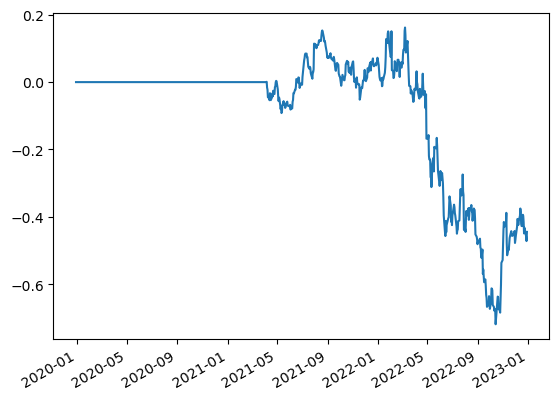

In [48]:
pnl.plot()